In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
# Constants
IMG_SIZE = 224  # Image size for resizing
INIT_LR = 1e-4  # Initial learning rate
EPOCHS = 30  # Number of training epochs
BATCH_SIZE = 64  # Batch size for training

In [3]:
# Dataset paths
BASE_DIR = r'D:\python\Skin_Type_Classification-Recommendation\skin_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
PRODUCT_DIR = r'D:\python\skincare products'

In [4]:
assert all(map(os.path.exists, [TRAIN_DIR, TEST_DIR, VALID_DIR, PRODUCT_DIR]))

In [5]:
# Load categories
categories = os.listdir(TRAIN_DIR)
class_counts = [len(os.listdir(os.path.join(TRAIN_DIR, c))) for c in categories]


C:\Users\DELL\AppData\Local\Temp\ipykernel_5848\3297360361.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=class_counts, palette='flare')


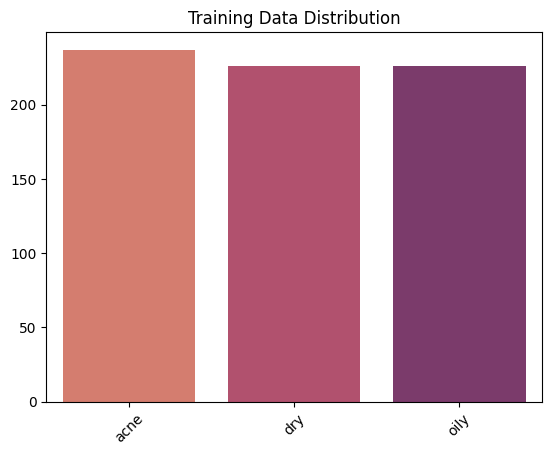

Total Training Images: 689


In [6]:
# Visualizing dataset distribution
sns.barplot(x=categories, y=class_counts, palette='flare')
plt.title('Training Data Distribution')
plt.xticks(rotation=45)
plt.show()
print(f'Total Training Images: {sum(class_counts)}')

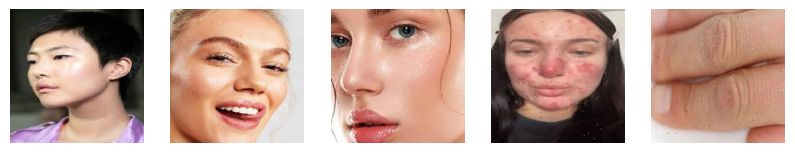

In [11]:
# Display sample images
fig, axes = plt.subplots(1, 5, figsize=(10, 4))
sample_images = random.sample(
    [os.path.join(TRAIN_DIR, c, img) for c in categories for img in os.listdir(os.path.join(TRAIN_DIR, c))],
    min(5, sum(class_counts))
)
for ax, img_path in zip(axes, sample_images):
    ax.imshow(load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE)))
    ax.axis('off')
plt.show()

In [12]:
# Data Loading
X, Y = [], []
for category in categories:
    for img_name in os.listdir(os.path.join(TRAIN_DIR, category)):
        img = load_img(os.path.join(TRAIN_DIR, category, img_name), target_size=(IMG_SIZE, IMG_SIZE))
        X.append(img_to_array(img))
        Y.append(category)

X = np.array(X, dtype='float32') / 255.0  # Normalize pixel values
Y = to_categorical(LabelEncoder().fit_transform(Y))


In [13]:
# Train-test split
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)

In [14]:
# Model Definition
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = AveragePooling2D(pool_size=(7, 7))(base_model.output)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(len(categories), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=out)


In [15]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

In [16]:
#compile Modal
model.compile(optimizer=Adam(learning_rate=INIT_LR), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train the Model
history = model.fit(trainX, trainY, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(testX, testY))

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.4046 - loss: 1.4359 - val_accuracy: 0.5507 - val_loss: 0.9351
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.5116 - loss: 1.0390 - val_accuracy: 0.6884 - val_loss: 0.7579
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6399 - loss: 0.7974 - val_accuracy: 0.8043 - val_loss: 0.6287
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.7807 - loss: 0.5720 - val_accuracy: 0.8188 - val_loss: 0.5499
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8255 - loss: 0.5043 - val_accuracy: 0.8551 - val_loss: 0.4872
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8442 - loss: 0.4516 - val_accuracy: 0.8551 - val_loss: 0.4403
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8572 - loss: 0.4096 - val_accuracy: 0.8623 - val_loss: 0.4127
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8791 - loss: 0.3674 - val_accuracy: 0.8696 - val_loss: 0.3871
Epoch 9/

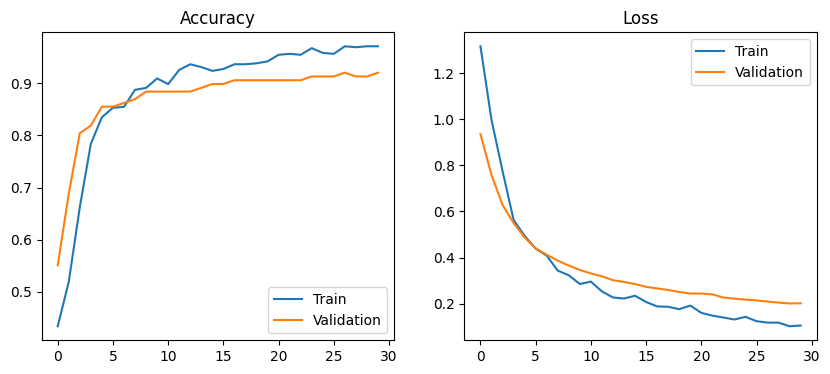

In [18]:
# Plot Accuracy and Loss
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, metric, title in zip(axes, ['accuracy', 'loss'], ['Accuracy', 'Loss']):
    ax.plot(history.history[metric], label='Train')
    ax.plot(history.history[f'val_{metric}'], label='Validation')
    ax.set_title(title)
    ax.legend()
plt.show()

In [19]:
# Classification Report
y_pred = np.argmax(model.predict(testX), axis=1)
y_true = np.argmax(testY, axis=1)
print(f'Model Accuracy: {np.mean(y_pred == y_true) * 100:.2f}%')
print(classification_report(y_true, y_pred, target_names=categories))

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
Model Accuracy: 92.03%
              precision    recall  f1-score   support

        acne       0.94      0.91      0.92        54
         dry       0.97      0.90      0.94        40
        oily       0.86      0.95      0.90        44

    accuracy                           0.92       138
   macro avg       0.92      0.92      0.92       138
weighted avg       0.92      0.92      0.92       138



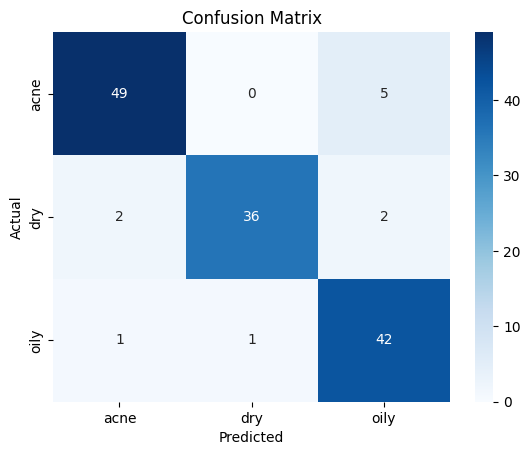

In [20]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Product Recommendation
def recommend_product(skin_type):
    path = os.path.join(PRODUCT_DIR, skin_type.lower() + 'skinproducts')
    if os.path.exists(path):
        product_imgs = [f for f in os.listdir(path) if f.endswith(('jpg', 'png'))][:3]
        if product_imgs:
            fig, axes = plt.subplots(1, len(product_imgs), figsize=(10, 4))
            for ax, img_name in zip(axes, product_imgs):
                ax.imshow(load_img(os.path.join(path, img_name), target_size=(100, 100)))
                ax.axis('off')
            plt.show()
        else:
            print(f'No products available for {skin_type}')
    else:
        print(f'No product directory found for {skin_type}')

In [22]:
# Skin Type Prediction
def predict_skin_type(image_path):
    if os.path.exists(image_path):
        img = img_to_array(load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))) / 255.0
        prediction = np.argmax(model.predict(np.expand_dims(img, axis=0)), axis=1)[0]
        skin_type = categories[prediction]
        print(f'Predicted Skin Type: {skin_type}')
        plt.imshow(load_img(image_path))
        plt.title(f'Predicted: {skin_type}')
        plt.axis('off')
        plt.show()
        recommend_product(skin_type)
    else:
        print(f'Error: Image path "{image_path}" does not exist.')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Predicted Skin Type: oily


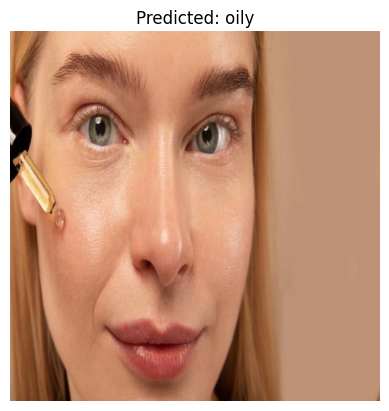

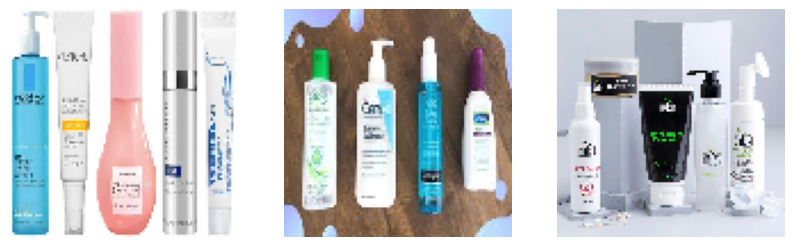

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Predicted Skin Type: acne


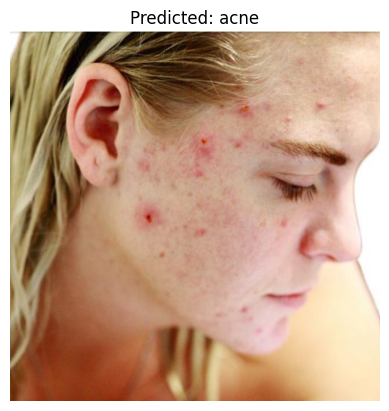

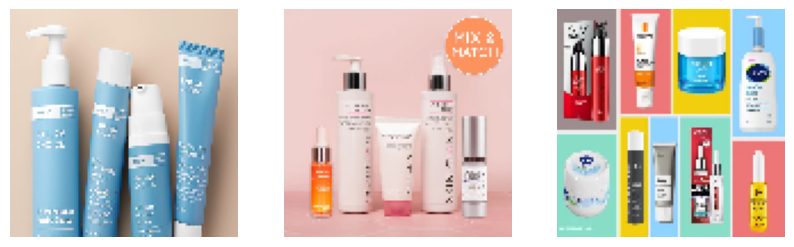

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Predicted Skin Type: dry


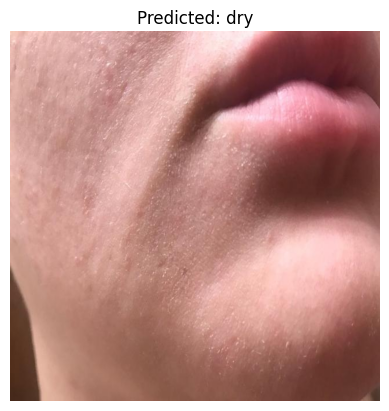

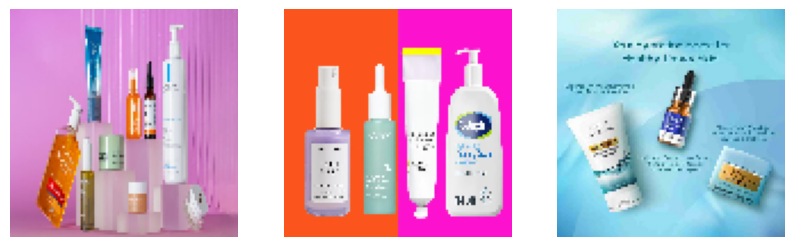

In [23]:
# Test prediction
for img_path in [
    r'D:\python\Skin_Type_Classification-Recommendation\skin_dataset\test\oily\Face-Oil_jpg.rf.cf730f2e94a901735c3f6d9134f0aced.jpg',
    r'D:\python\Skin_Type_Classification-Recommendation\skin_dataset\test\acne\38_jpg.rf.1e4b96646a374bf71fdb63167f3e7093.jpg',
    r'D:\python\Skin_Type_Classification-Recommendation\skin_dataset\test\dry\dry24_jpg.rf.10096fef9db760b56a2a090aaf6a621e.jpg',
]:
    predict_skin_type(img_path)